## Excercise 6.16

In [248]:
# Expect this program to run for 30 minutes or more
# Load package
import numpy as np
from scipy.stats import norm
import random
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd


from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler


import tensorflow as tf
from tensorflow.keras.layers import Dense
from tensorflow import keras

from numpy.random import seed
seed(100)

import matplotlib.pyplot as plt
from IPython.display import clear_output

n = norm.pdf
N = norm.cdf

import warnings
warnings.filterwarnings("ignore")

## Basic: Intitial task exploring NN

In [249]:
# Load option data 
option_dataset = pd.read_csv('Option_Data.csv')
option_dataset.head(3)

,Spot price,Strike Price,Risk Free Rate,Volatility,Maturity,Dividend,Option Price,Noise,Option Price with Noise
0,55.84,72.592,0.013,0.276,1.78,0,3.569203,-0.262465,3.306738
1,57.96,34.776,0.033,0.171,0.85,0,24.146475,0.051402,24.197877
2,43.70,52.440,0.041,0.262,1.19,0,2.764509,0.172955,2.937464


In [250]:
# Include option price with and without noise in data set splitting for later BS mean error calculation on test set
y_ = option_dataset[['Option Price with Noise','Option Price']]
X_ = option_dataset[['Spot price', 'Strike Price', 'Risk Free Rate','Volatility','Maturity','Dividend']]

# Divide data into training set and test set(note that random seed is set)
X_train,X_test,y_train,y_test=train_test_split(X_,y_,test_size=0.5,random_state=100)

# Divide training set into training and validation set
X_train,X_val,y_train,y_val=train_test_split(X_train,y_train,test_size=0.5,random_state=100)

In [251]:
# Scale features based on Z-Score
scaler = StandardScaler()
scaler.fit(X_train)


X_scaled_train = scaler.transform(X_train)
X_scaled_vals = scaler.transform(X_val)
X_scaled_test = scaler.transform(X_test)
y_train = np.asarray(y_train)
y_val = np.asarray(y_val)
y_test = np.asarray(y_test)

In [252]:
# Base model
model = keras.models.Sequential([Dense(20,activation = "sigmoid",input_shape = (6,)),
                                 Dense(20,activation = "sigmoid"),Dense(20,activation = "sigmoid"),
                                Dense(1)])

# Changing the number of hidden layers
two_layers = keras.models.Sequential([Dense(20,activation = "sigmoid",input_shape = (6,)),
                                 Dense(20,activation = "sigmoid"),Dense(20,activation = "sigmoid"),
                                 Dense(20,activation = "sigmoid"),Dense(20,activation = "sigmoid"),
                                Dense(1)])

three_layers = keras.models.Sequential([Dense(20,activation = "sigmoid",input_shape = (6,)),
                                 Dense(20,activation = "sigmoid"),Dense(20,activation = "sigmoid"),
                                 Dense(20,activation = "sigmoid"),Dense(20,activation = "sigmoid"),
                                 Dense(20,activation = "sigmoid"),Dense(20,activation = "sigmoid"),
                                Dense(1)])

# Changing the number of neurons
fewer_neurons = keras.models.Sequential([Dense(10,activation = "sigmoid",input_shape = (6,)),
                                 Dense(10,activation = "sigmoid"),Dense(10,activation = "sigmoid"),
                                Dense(1)])

more_neurons = keras.models.Sequential([Dense(10,activation = "sigmoid",input_shape = (6,)),
                                 Dense(10,activation = "sigmoid"),Dense(10,activation = "sigmoid"),
                                Dense(1)])

# List for all the models
models = [model, two_layers, three_layers, fewer_neurons, more_neurons]

In [253]:
model.summary()

Model: "sequential_47"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_174 (Dense)           (None, 20)                140       
                                                                 
 dense_175 (Dense)           (None, 20)                420       
                                                                 
 dense_176 (Dense)           (None, 20)                420       
                                                                 
 dense_177 (Dense)           (None, 1)                 21        
                                                                 
Total params: 1,001
Trainable params: 1,001
Non-trainable params: 0
_________________________________________________________________


In [254]:
# Complie function allows you to choose your measure of loss and optimzer
for mdl in models:
    mdl.compile(loss = "mae",optimizer = "Adam")

# Create checkpoints abd early stop files for each model
checkpoints, early_stops = [], []
for n, mdl in enumerate(models, 1):
    checkpoints.append(keras.callbacks.ModelCheckpoint("Model " + str(n) + ".h5",save_best_only = True))
    early_stops.append(keras.callbacks.EarlyStopping(patience = 5000,restore_best_weights = True))
    
# Training with callback
history_ = []
for ind, mdl in enumerate(models, 0): 
    history_.append(mdl.fit(X_scaled_train,y_train[:,0],
                            epochs= 10000,verbose = 0, 
                            validation_data=(X_scaled_vals,y_val[:,0]),
                callbacks=[checkpoints[ind],early_stops[ind]]))

In [255]:
# Load the best models saved and calcuate MAE for testing set for each case
model_names = ["Model " + str(i) for i in range(1,6)]
mae_test_vals, mean_error, std_error, mean_error_vs_BS_price, std_error_vs_BS_price, BS_mean_error, BS_std_error = [],[],[],[],[],[],[]

for ind, mdl in enumerate(models, 0):
    temp_model = keras.models.load_model(str(model_names[ind])+".h5")
    mae_test_vals.append(mdl.evaluate(X_scaled_test,y_test[:,0],verbose= 0))

    # Obtain each models predictions
    model_prediction = mdl.predict(X_scaled_test)

    # Black Scholes Statistics
    mean_error.append(np.average(model_prediction.T - y_test[:,0])) # Mean error on test set
    std_error.append(np.std(model_prediction.T - y_test[:,0])) # Standard deviation of error on test set

    # Neural Network Statistics
    mean_error_vs_BS_price.append(np.average(model_prediction.T - y_test[:,1])) # Mean error on test set vs. option price with noise
    std_error_vs_BS_price.append(np.std(model_prediction.T - y_test[:,1])) # Standard deviation of error on test set vs. option price with noise
    BS_mean_error.append(np.average(y_test[:,0] - y_test[:,1])) # Mean error on test set vs. BS analytical formula price
    BS_std_error.append(np.std(y_test[:,0] - y_test[:,1]))# Standard deviation of error on 

157/157 [==============================] - 0s 423us/step


In [256]:
# Naming conventions
model_tags = ["Base", "Add 1 Hidden Layers", "Add 2 Hidden Layers", "Reduced Neurons", "Increased Neurons"]
metrics_tags = ["MAE test values", "Mean Error", "Std error", "Mean error vs BS price", "Std error vs BS price", "BS mean error", "BS std error"]

# Map variables
res_ = list(zip(mae_test_vals, mean_error, std_error, mean_error_vs_BS_price, std_error_vs_BS_price, BS_mean_error, BS_std_error))
results = pd.DataFrame(res_, index=model_tags, columns = metrics_tags)

# Print results
results

,MAE test values,Mean Error,Std error,Mean error vs BS price,Std error vs BS price,BS mean error,BS std error
Base,0.124232,-0.010693,0.156793,-0.007305,0.054595,0.003388,0.148538
Add 1 Hidden Layers,0.125323,-0.016027,0.156818,-0.012639,0.054904,0.003388,0.148538
Add 2 Hidden Layers,0.125010,-0.012028,0.157305,-0.008641,0.056011,0.003388,0.148538
Reduced Neurons,0.130632,0.023391,0.162280,0.026779,0.066295,0.003388,0.148538
Increased Neurons,0.135018,-0.023999,0.168813,-0.020612,0.080065,0.003388,0.148538


Model 1: Base


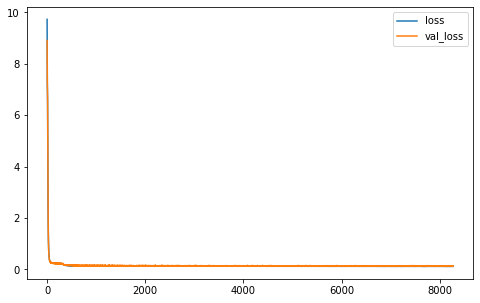

Model 2: Add 1 Hidden Layers


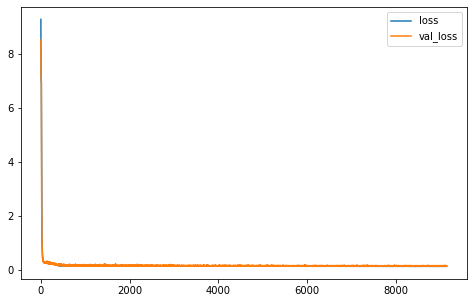

Model 3: Add 2 Hidden Layers


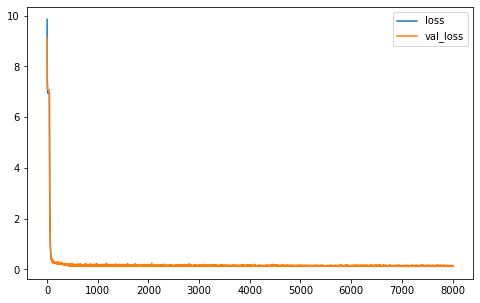

Model 4: Reduced Neurons


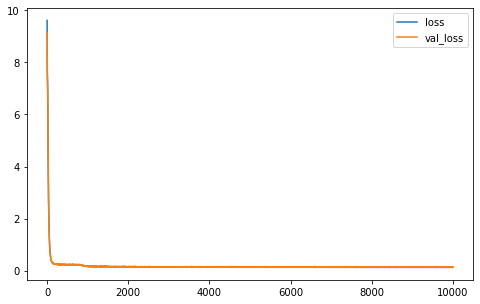

Model 5: Increased Neurons


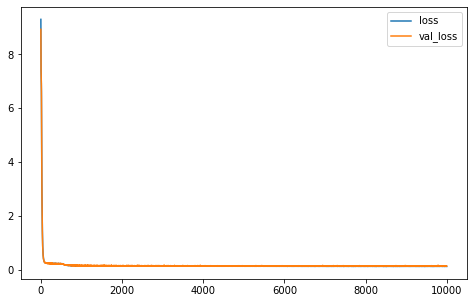

In [257]:
# Plot training history
for n, hist in enumerate(history_, 0): 
    print("Model " + str(n+1) + ": "+ str(model_tags[n])) 
    pd.DataFrame(hist.history).plot(figsize=(8,5))
    plt.show()

## Advanced: Adding Bitcoin options & NN Hyperparameter tuning with Keras Tuner

In [258]:
""" Download CC-Option Data from Deribit via public API """

"""
Source
Matteo Bottacini -- matteo.bottacini@usi.ch
Last Update: February 21, 2021
"""

# import modules
import json
import requests
from tqdm import tqdm
import sqlite3
import datetime


# functions
def get_option_name_and_settlement(coin):
    """
    :param coin: crypto-currency coin name ('BTC', 'ETH')

    :return: 2 lists:
                        1.  list of traded options for the selected coin;
                        2.  list of settlement period for the selected coin.
    """

    # requests public API
    r = requests.get("https://test.deribit.com/api/v2/public/get_instruments?currency=" + coin + "&kind=option")
    result = json.loads(r.text)

    # get option name
    name = pd.json_normalize(result['result'])['instrument_name']
    name = list(name)

    # get option settlement period
    settlement_period = pd.json_normalize(result['result'])['settlement_period']
    settlement_period = list(settlement_period)

    return name, settlement_period


def get_option_data(coin):
    """
    :param coin: crypto-currency coin name ('BTC', 'ETH')
    :return: pandas data frame with all option data for a given coin
    """

    # get option name and settlement
    coin_name = get_option_name_and_settlement(coin)[0]
    settlement_period = get_option_name_and_settlement(coin)[1]

    # initialize data frame
    coin_df = []

    # initialize progress bar
    pbar = tqdm(total=len(coin_name))

    # loop to download data for each Option Name
    for i in range(len(coin_name)):
        # download option data -- requests and convert json to pandas
        r = requests.get('https://test.deribit.com/api/v2/public/get_order_book?instrument_name=' + coin_name[i])
        result = json.loads(r.text)
        df = pd.json_normalize(result['result'])

        # add settlement period
        df['settlement_period'] = settlement_period[i]

        # append data to data frame
        coin_df.append(df)

        # update progress bar
        pbar.update(1)

    # finalize data frame
    coin_df = pd.concat(coin_df)

    # remove useless columns from coin_df
    columns = ['state', 'estimated_delivery_price']
    coin_df.drop(columns, inplace=True, axis=1)

    # close the progress bar
    pbar.close()

    return coin_df

# Commented out as I've already run it. Will take about 20-30 minutes to append. 

# # print data and time for log
# print('Date and time: ' +  datetime.datetime.now().strftime("%d/%m/%Y %H:%M:%S") + ' , format: dd/mm/yyyy hh:mm:ss')

# # download data -- BTC and ETH Options
# btc_data = get_option_data('BTC')
# eth_data = get_option_data('ETH')

# # export data to .csv -- append to existing
# btc_data.to_csv(r'btc_option_data.csv', index=0, mode='a', header=False)
# eth_data.to_csv(r'eth_option_data.csv', index=0, mode='a', header=False)

# # transform each element of the data frames into strings for sqlite3
# btc_data = btc_data.astype(str)
# eth_data = eth_data.astype(str)

# # connect to the SQLite3 database -- option_data.db
# conn = sqlite3.connect('option-data.db')
# print('Connection established with SQLite3 server: option-data.db')

# # create/update BTC and ETH tables in the database
# btc_data.to_sql(name='btc_option_data', con=conn, if_exists='append', chunksize=None, index=False)
# print('BTC data appended')

# eth_data.to_sql(name='eth_option_data', con=conn, if_exists='append', chunksize=None, index=False)
# print('ETH data appended')


In [259]:
# Read data
btc_data = pd.read_csv(r'btc_option_data.csv')
eth_data = pd.read_csv(r'eth_option_data.csv')
datasets = btc_data, eth_data
print([i.shape for i in datasets])
# See the columns better
np.reshape(btc_data.columns.tolist(),(16,2))

[(1288, 32), (1370, 32)]


array([['underlying_price', 'underlying_index'],
       ['timestamp', 'open_interest'],
       ['min_price', 'max_price'],
       ['mark_price', 'mark_iv'],
       ['last_price', 'interest_rate'],
       ['instrument_name', 'index_price'],
       ['change_id', 'bids'],
       ['bid_iv', 'best_bid_price'],
       ['best_bid_amount', 'best_ask_price'],
       ['best_ask_amount', 'asks'],
       ['ask_iv', 'stats.volume'],
       ['stats.price_change', 'stats.low'],
       ['stats.high', 'greeks.vega'],
       ['greeks.theta', 'greeks.rho'],
       ['greeks.gamma', 'greeks.delta'],
       ['settlement_period', 'settlement_price']], dtype='<U18')

In [260]:
# Breakdown key values in instrument name and remove expired options
ins_breakdown = ['coin', 'expiry_date', 'strike_price','option_type']
clean_data = []

# Assume date
date_of_analysis = '21-Apr-2023'

for i in datasets:
    i[ins_breakdown] = i['instrument_name'].str.split('-', expand = True)
    i['expiry_date'] = pd.to_datetime(i['expiry_date'], infer_datetime_format=True)
    i['curr_date'] = pd.to_datetime(date_of_analysis, infer_datetime_format= True)

    # Additional cleaning 
    i['maturity'] = (i['expiry_date'] - i['curr_date']) / np.timedelta64(1, 'Y')
    
    # Store in clean data list 
    clean_data.append(i.loc[i['expiry_date'] > i['curr_date']])

In [261]:
clean_data[0].isnull().sum().sort_values(ascending = False)[0:5]

stats.price_change    106
stats.low             106
stats.high            106
last_price              6
underlying_price        0
dtype: int64

In [262]:
clean_data[1].isnull().sum().sort_values(ascending = False)[0:5]

stats.price_change    288
stats.low             288
stats.high            288
last_price             44
greeks.gamma            0
dtype: int64

In [263]:
pd.set_option('display.max_columns', None)
clean_data[0].head(2)



,underlying_price,underlying_index,timestamp,open_interest,min_price,max_price,mark_price,mark_iv,last_price,interest_rate,instrument_name,index_price,change_id,bids,bid_iv,best_bid_price,best_bid_amount,best_ask_price,best_ask_amount,asks,ask_iv,stats.volume,stats.price_change,stats.low,stats.high,greeks.vega,greeks.theta,greeks.rho,greeks.gamma,greeks.delta,settlement_period,settlement_price,coin,expiry_date,strike_price,option_type,curr_date,maturity
1064,29411.08,index_price,1.681910e+12,547.8,0.5095,0.539,0.5243,137.6,0.5325,0,BTC-28APR23-14000-C,29411.08,16203631026,"[[0.517, 3.1], [0.472, 1.0], [0.04, 2.0], [0.0...",0.0,0.517,3.1,0.0,0.0,[],0.0,1.1,-1.5712,0.5325,0.541,0.02838,-0.22367,3.34750,0.0,0.99984,month,0.535339,BTC,2023-04-28,14000,C,2023-04-21,0.019165
1065,29411.08,index_price,1.681910e+12,701.7,0.0001,0.015,0.0000,137.6,0.0005,0,BTC-28APR23-14000-P,29411.08,16203622674,[],0.0,0.000,0.0,0.0,0.0,[],0.0,0.0,NaN,NaN,NaN,0.02838,-0.22367,-0.00121,0.0,-0.00016,month,0.000007,BTC,2023-04-28,14000,P,2023-04-21,0.019165


In [264]:
# Add black scholes clean option price
def get_bsm_price(S, K, T, r, sigma, option_type):
    d1 = (np.log(S/K) + (r + sigma**2/2)*T) / (sigma*np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    if option_type == 'C':
        return S * N(d1) - K * np.exp(-r*T)* N(d2)    
    elif option_type == 'P':
        return K*np.exp(-r*T)*N(-d2) - S*N(-d1)

# Add new columns, refine bid/ask columns & remove unimportant column
bsm_columns = ['underlying_price', 'strike_price','risk_free' ,'maturity', \
               'mark_iv', 'clean_price','mark_price']

dfs = []

j = 0
for i in clean_data:
    i['risk_free'] = 0.03

    i['clean_price'] = i.apply(lambda x:get_bsm_price(x['underlying_price'],
                                                      int(x['strike_price']),
                                                      x['maturity'],
                                                      x['risk_free'],
                                                      x['mark_iv']/100,
                                                      x['option_type']
                                                      ), axis = 1 )


    i = i[bsm_columns]
    j+=1

    dfs.append(i)

    # get the name and shape
    if j == 1:
        print('BTC', i.shape)
    if j == 2:
        print('ETH', i.shape)
    

BTC (224, 7)
ETH (306, 7)


In [265]:
df1 = dfs[0]
df2 = dfs[1]

df1.head(5)

,underlying_price,strike_price,risk_free,maturity,mark_iv,clean_price,mark_price
1064,29411.08,14000,0.03,0.019165,137.6,15419.169802,0.5243
1065,29411.08,14000,0.03,0.019165,137.6,0.042669,0.0000
1066,29411.67,16000,0.03,0.019165,137.6,13421.631896,0.4564
1067,29411.62,16000,0.03,0.019165,137.6,0.765197,0.0001
1068,29411.62,17000,0.03,0.019165,137.6,12423.846652,0.4226


## Divide data into Training, Validation and Test set

In [266]:
# set target y to be index_price, and training variables to everything else
y1, y2 = df1[['mark_price', 'clean_price']], df2[['mark_price', 'clean_price']]
x1, x2 = df1.drop(['mark_price', 'clean_price'], axis = 1), df2.drop(['mark_price', 'clean_price'], axis = 1)

def split(x,y):
    # Divide data into training set and test set(note that random seed is set)
    X_train,X_test,y_train,y_test=train_test_split(x,y,test_size=0.5,random_state=100)

    # Divide training set into training and validation set
    X_train,X_val,y_train,y_val=train_test_split(X_train,y_train,test_size=0.5,random_state=100)

    return [X_train, X_val, X_test], [y_train, y_val, y_test]

## Feature Scaling

In [267]:
from sklearn.preprocessing import MaxAbsScaler

def scaler(df):
    scaler = MaxAbsScaler()
    scaler.fit(df)
    scaled = scaler.transform(df)
    return pd.DataFrame(scaled, columns=df.columns)


x_btc_list , y_btc_list = split(x1, y1)
x_eth_list , y_eth_list = split(x2, y2)

def scale_x(x_list):
    scaled_x_list = []
    for i in x_list:
        scaled_x_list.append(scaler(i))
    return scaled_x_list

x_scaled_btc , x_scaled_eth = scale_x(x_btc_list), scale_x(x_eth_list)

In [268]:
x_train_btc, x_val_btc, x_test_btc = x_scaled_btc[0], x_scaled_btc[1], x_scaled_btc[2]
y_train_btc, y_val_btc, y_test_btc = y_btc_list[0], y_btc_list[1], y_btc_list[2]

x_train_eth, x_val_eth, x_test_eth = x_scaled_eth[0], x_scaled_eth[1] , x_scaled_eth[2] 
y_train_eth, y_val_eth, y_test_eth = y_eth_list[0], y_eth_list[1], y_eth_list[2]

# Tuning Neural Networks: Hyperparameters

In [269]:
# Source https://www.tensorflow.org/tutorials/keras/keras_tuner

# Tune the model using RandomSearch
import kerastuner.tuners as kt


def model_builder(hp):
  model = keras.Sequential()
  model.add(keras.layers.Flatten(input_shape=(5, )))

  # Tune the number of units in the first Dense layer, optimal value between 32-512
  hp_units = hp.Int('units', min_value=32, max_value=512, step=32)
  model.add(keras.layers.Dense(units=hp_units, activation='sigmoid'))
  model.add(keras.layers.Dense(1))

  # Tune the learning rate for the optimizer, optimal value from 0.01, 0.001, or 0.0001
  hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])

  model.compile(optimizer=keras.optimizers.Adam(learning_rate=hp_learning_rate),
                loss= 'mae',
                metrics=[tf.keras.metrics.MeanAbsoluteError()])

  return model

In [270]:
# BTC Tuner
tuner = kt.Hyperband(
  model_builder, 
  objective = 'loss',
  executions_per_trial = 3,
  directory = '6.16 tuners',
  project_name='btc_tuner'
)


# Tune on train/val data
tuner.search(x_train_btc, 
             y_train_btc['mark_price'], 
            epochs=10000, 
            validation_data=(x_val_btc, y_val_btc['mark_price']))

# Get the optimal hyperparameters
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"""
The optimal number of units in the first densely-connected
layer is {best_hps.get('units')} and the optimal learning rate for the optimizer
is {best_hps.get('learning_rate')}.
""")


INFO:tensorflow:Reloading Tuner from 6.16 tuners\btc_tuner\tuner0.json
INFO:tensorflow:Oracle triggered exit

The optimal number of units in the first densely-connected
layer is 352 and the optimal learning rate for the optimizer
is 0.0001.



In [271]:
# ETH Tuner
tuner2 = kt.Hyperband(
  model_builder, 
  objective = 'loss',
  executions_per_trial = 3,
  directory = '6.16 tuners',
  project_name='eth_tuner'
)

# Tune on train val data
tuner2.search(x_train_eth, 
              y_train_eth['mark_price'], 
              epochs=10000, 
              validation_data=(x_val_eth, y_val_eth['mark_price'],))


# Get the optimal hyperparameters
best_hps2=tuner2.get_best_hyperparameters(num_trials=1)[0]

print(f"""
The optimal number of units in the first densely-connected
layer is {best_hps2.get('units')} and the optimal learning rate for the optimizer
is {best_hps2.get('learning_rate')}.
""")

INFO:tensorflow:Reloading Tuner from 6.16 tuners\eth_tuner\tuner0.json
INFO:tensorflow:Oracle triggered exit

The optimal number of units in the first densely-connected
layer is 128 and the optimal learning rate for the optimizer
is 0.001.



# Tuning Neural Networks: Epochs

In [281]:
model_btc = tuner.hypermodel.build(best_hps)
history_btc = model_btc.fit(x_train_btc, y_train_btc['mark_price'], epochs=50000, validation_split=0.5, verbose=0)

val_acc_per_epoch_btc = history_btc.history['mean_absolute_error']
best_epoch_btc = val_acc_per_epoch_btc.index(min(val_acc_per_epoch_btc)) + 1
print('Best epoch: %d' % (best_epoch_btc,))

Best epoch: 46764


In [282]:
model_eth = tuner2.hypermodel.build(best_hps2)
history_eth = model_eth.fit(x_train_eth, y_train_eth['mark_price'], epochs=50000, validation_split=0.5, verbose = 0)

val_acc_per_epoch_eth = history_eth.history['mean_absolute_error']
best_epoch_eth = val_acc_per_epoch_eth.index(min(val_acc_per_epoch_eth)) + 1
print('Best epoch: %d' % (best_epoch_eth,))

Best epoch: 49131


## Calculate prediction error for both NN and BS analytical formula

In [283]:
# Reinstantiating models from above
hypermodel_btc = tuner.hypermodel.build(best_hps)
hypermodel_btc.fit(x_train_btc, y_train_btc['mark_price'], epochs=best_epoch_btc, validation_split=0.5, verbose =0)
eval_result_btc = hypermodel_btc.evaluate(x_test_btc, y_test_btc['mark_price'])


print("[test loss, test accuracy]:", eval_result_btc)

4/4 [==============================] - 0s 667us/step - loss: 0.1798 - mean_absolute_error: 0.1798
[test loss, test accuracy]: [0.1797875612974167, 0.1797875612974167]


In [284]:
# Reinstantiating models from above
hypermodel_eth = tuner.hypermodel.build(best_hps2)
hypermodel_eth.fit(x_train_eth, y_train_eth['mark_price'], epochs=best_epoch_eth, validation_split=0.5, verbose = 0)
eval_result_eth = hypermodel_eth.evaluate(x_test_eth, y_test_eth)


print("[test loss, test accuracy]:", eval_result_eth)

5/5 [==============================] - 0s 751us/step - loss: 340.5731 - mean_absolute_error: 340.5731
[test loss, test accuracy]: [340.57305908203125, 340.57305908203125]


In [285]:
len(hypermodel_btc.predict(x_test_btc))

4/4 [==============================] - 0s 334us/step


112

In [286]:
# Create storage lists
def get_mae(model, x_scaled_test, y_test):
    
    y_pred = model.predict(x_scaled_test)

    # Black Scholes Statistics
    mean_error = np.average(y_pred.flatten() - y_test['mark_price']) # Mean error on test set
    std_error = np.std(y_pred.flatten() - y_test['mark_price']) # Standard deviation of error on test set

    # Neural Network Statistics
    mean_error_vs_BS_price = np.average(y_pred.flatten() - y_test['clean_price']) # Mean error on test set vs. option price with noise
    std_error_vs_BS_price = np.std(y_pred.flatten()- y_test['clean_price']) # Standard deviation of error on test set vs. option price with noise
    BS_mean_error = np.average(y_test['mark_price'] - y_test['clean_price']) # Mean error on test set vs. BS analytical formula price
    BS_std_error = np.std(y_test['mark_price'] - y_test['clean_price'])# Standard deviation of error on test set vs. BS analytical formula pric

    out = [mean_error, std_error, mean_error_vs_BS_price , std_error_vs_BS_price, BS_mean_error, BS_std_error]

    return pd.DataFrame(np.reshape([round(i, 3) for i in out],(1,6)), columns= ['Mean Error', 'Std Error', \
                                                              'Mean Error against BS Price', \
                                                              'Std error against BS Price',\
                                                              'BS Mean Error',\
                                                              'BS Std Error'])

# Get metrics
btc_metrics = get_mae(hypermodel_btc, x_test_btc, y_test_btc)
eth_metrics = get_mae(hypermodel_eth, x_test_eth, y_test_eth)
btc_metrics['Data'] = 'BTC'
eth_metrics['Data'] = 'ETH'
final_metrics = pd.concat([btc_metrics, eth_metrics])
final_metrics

5/5 [==============================] - 0s 501us/step


,Mean Error,Std Error,Mean Error against BS Price,Std error against BS Price,BS Mean Error,BS Std Error,Data
0,0.017,0.253,-5866.347,6822.365,-5866.364,6822.130,BTC
0,-0.088,0.569,-680.770,1277.860,-680.681,1277.331,ETH


# Show predictions

In [287]:
def plot_preds(model, x_scaled_test, y_test):
    y_pred = model.predict(x_scaled_test)

    plt.scatter(y_test['mark_price'], 
                y_pred,
                color='red',
                linewidth=0.3,
                alpha=1, 
                s=2
                )
    plt.xlabel('Actual Price',fontsize=20)
    plt.ylabel('Predicted Price',fontsize=20) 
    plt.show()

4/4 [==============================] - 0s 667us/step


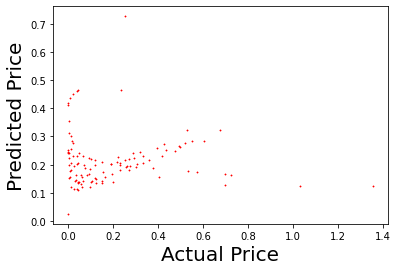

In [288]:
# Print predictions BTC
plot_preds(hypermodel_btc, x_test_btc, y_test_btc)

5/5 [==============================] - 0s 501us/step


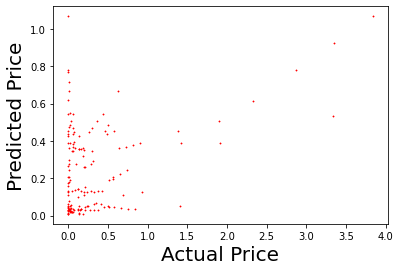

In [289]:
# Print predictions ETH
plot_preds(hypermodel_eth, x_test_eth, y_test_eth)